In [1]:
from helpers import *
from sbi.analysis import pairplot
warnings.filterwarnings("ignore")

In [20]:
SEED = 2
np.random.seed(SEED)
torch.manual_seed(SEED)
subfolder = "0"
data_path = "91_param_"
os.makedirs(join(data_path, subfolder, "figs"), exist_ok=True)

In [5]:
opts = json.load(open(join(data_path, "opts.json"), "r"))
features_info = json.load(open(join(data_path, "features_info.json"), "r"))
prune_dict = pickle.load(open(join(data_path, subfolder, f"prune_dict.pkl"), 'rb'))
features = list(opts.keys())

In [7]:
def prune_features(x, threshold=0.001):

    if isinstance(x, torch.Tensor):
        x = x.numpy()
    if x.ndim == 1:
        x = x.reshape(1, -1)

    selector = VarianceThreshold(threshold=threshold)
    selector.fit(x)
    cols = selector.get_support()
    return cols


def get_features(bold, features, opts):

    if bold.ndim == 2:
        F = Features(features, opts)
        stat_vec, stat_info = F.calc_features(bold)
        return stat_vec, stat_info
    return None, None


def load_stats(rank, i_batch, data_path):
    fname = join(data_path, "stats", f"stats_{rank:05d}_{i_batch:05d}.pkl")
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            data = pickle.load(f)
        return data['stats'], data['theta']
    else:
        return None, None


def load_stats_all(n_rank, n_batch, mini_batch_size, data_path):

    # n_batch = int(np.ceil(n_sim / n_rank/ mini_batch_size))
    Theta = []
    X = []
    for i in range(n_rank):
        for j in range(n_batch):
            stats_vec, theta_vec = load_stats(i, j, data_path)
            if stats_vec is not None:
                for k in range(len(theta_vec)):
                    if not np.isnan(stats_vec[k]).any():
                        Theta.append(theta_vec[k])
                        X.append(stats_vec[k])

    Theta = np.array(Theta).astype(np.float32)
    X = np.array(X).astype(np.float32)
    return Theta, X


def wrapper_features(x, info, threshold=0.001, prune_dict=None):

    flag = False
    if prune_dict is None:
        flag = True
        prune_dict = {}

    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
        if x.ndim == 1:
            x = x.reshape(1, -1)

    if flag:
        prune_dict['all'] = prune_features(x, threshold)
    x = x[:, prune_dict['all']].numpy()

    return x, prune_dict

def wrap_sim(theta, features, opts):

    with open(join(data_path, "parameters.pkl"), 'rb') as f:
        parameters = pickle.load(f)
    parameters['data_path'] = data_path
    _, stat_vec, bold = wrapper_simulate(0, parameters, theta, features, opts)
    return stat_vec, bold


def wrap_i(G_obs, a_obs, b_obs, eta_obs, subname, features, opts, 
           prune_dict, features_info):
    print(f"simulating bold signal... {subname}")

    if isinstance(eta_obs, np.ndarray):
        eta_obs = eta_obs.tolist()
    theta_obs = np.array(G_obs + a_obs + b_obs + eta_obs).reshape(1, -1)

    stat_obs, bold_obs = wrap_sim(theta_obs.squeeze(), features, opts)
    bold_obs.shape, stat_obs.shape
    stat_obs_w = wrapper_features(stat_obs, features_info, prune_dict=prune_dict)[0]
    posterior = pickle.load(open(join(data_path, subfolder, f"posterior.pickle"), "rb"))['posterior']
    samples = posterior.sample((10000,), x=stat_obs_w)
    torch.save(samples, join(data_path, subfolder, f"samples_{subname}.pt"))
    np.savez(join(data_path, subfolder, f"bold_{subname}.npz"),
         bold=bold_obs, stat_obs=stat_obs,
         theta=theta_obs, stat_obs_w=stat_obs_w)

    data = np.load(join(data_path, subfolder, f"bold_{subname}.npz"))
    theta_obs = data['theta']
    samples = torch.load(join(data_path, subfolder, f"samples_{subname}.pt"))

    plot_triangle(samples, G_obs, a_obs, b_obs, subname)
    plot_eta(samples, theta_obs, subname)


def plot_triangle(samples, G_obs, a_obs, b_obs, subname):
    fig, ax = pairplot(
        samples[:, :3],
        points=[G_obs + a_obs + b_obs],
        figsize=(8, 8),
        limits=[[0, 1.1], [0,1], [0,1]],
        labels=["G", r"$\alpha$", r"$\beta$"],
        upper='kde',
        diag='kde',
        points_colors="r",
        samples_colors="k",
        points_offdiag={'markersize': 10})
    fig.savefig(join(data_path, subfolder, f"figs/g_{subname}.png"), dpi=300, bbox_inches="tight")
    # plt.close()

def plot_eta(samples, theta_obs, subname):
    eta_samples = samples[:, 3:]
    eta_true = theta_obs[0, 3:]

    _, ax = plt.subplots(1, figsize=(20, 4))
    parts = ax.violinplot(eta_samples.T, widths=0.7, showmeans=1, showextrema=1)
    ax.plot(np.r_[1:eta_true.shape[0]+1], eta_true, 'o', color='r', alpha=0.9, ms=8)
    ax.axhline(y=-4.6, color = 'gray', linestyle = '--', lw=3, alpha=0.5)
    ax.set_ylabel(' Posterior ' + r'${(\eta_i)}$')
    ax.set_xlabel('Regions')
    ax.tick_params(labelsize=14)

    for pc in parts['bodies']:
        pc.set_facecolor('green')
        pc.set_edgecolor('black')
        pc.set_alpha(0.3)
    ax.tick_params(labelsize=18)
    ax.margins(x=0.01)
    plt.savefig(join(data_path, subfolder, f"figs/eta_{subname}.png"), dpi=300, bbox_inches="tight")
    # plt.close()


In [ ]:
# G_obs = [0.6]
# a_obs = [0.2]
# b_obs = [0.3]
# eta_obs = np.random.uniform(-6, -3.5, 88)

# subname=7
# wrap_i(G_obs, a_obs, b_obs, eta_obs, subname, features, opts, prune_dict, features_info)

In [16]:
torch.set_num_threads(8)
data = np.load(join(data_path, subfolder, "bold_7.npz"))
posterior = pickle.load(open(join(data_path, subfolder, "posterior.pickle"), "rb"))['posterior']
bold = data['bold']
stat_obs_w = data['stat_obs_w']
theta_obs = data['theta']
samples = posterior.sample((10000,), x=stat_obs_w)
stat_obs_w.shape, theta_obs.shape, bold.shape

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

((1, 1938), (1, 91), (88, 399))

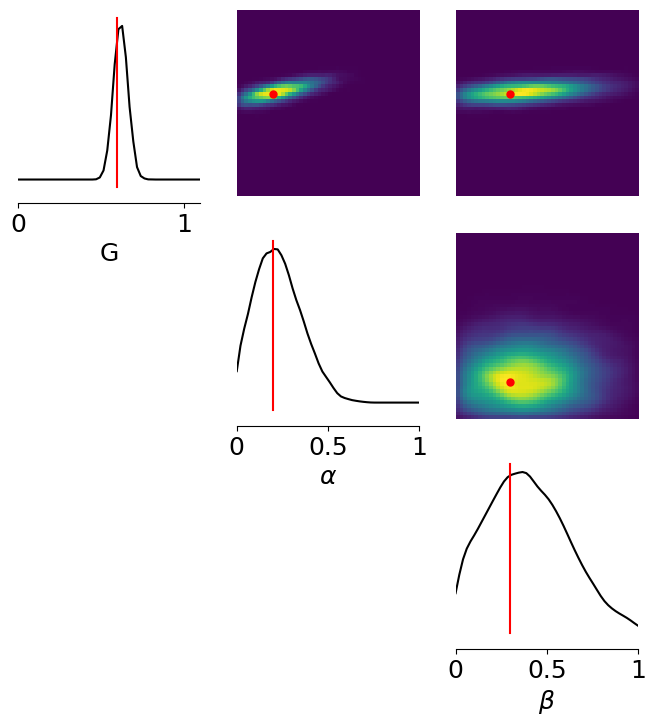

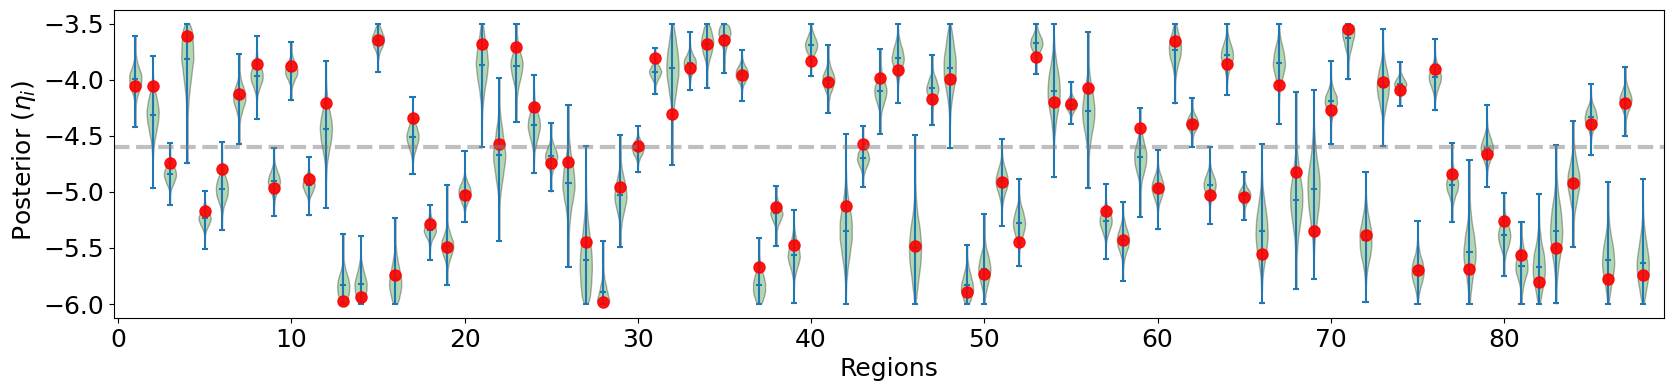

In [25]:
subname=7

G_obs, a_obs, b_obs = theta_obs[0, :3]
plot_triangle(samples, [G_obs], [a_obs], [b_obs], subname)
plot_eta(samples, theta_obs, subname);